In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.defchararray import find
from pandas.api.types import CategoricalDtype
from scipy import stats
from sklearn import linear_model, preprocessing
from sklearn.metrics import (RocCurveDisplay, auc, confusion_matrix,
                             mean_squared_error, roc_curve)
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

from label_flip_revised.simple_nn_model import SimpleModel
from label_flip_revised.torch_utils import evaluate, train_model
from label_flip_revised.utils import create_dir, open_csv


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
workspace_names = ['label_flip_revised'] + [f'label_flip_revised_{i:02d}' for i in range(2, 6)]

print(workspace_names)

['label_flip_revised', 'label_flip_revised_02', 'label_flip_revised_03', 'label_flip_revised_04', 'label_flip_revised_05']


In [4]:
rocA = 'roc_real_NN-FALFA.csv'
rocB = 'roc_real_SVM-ALFA.csv'

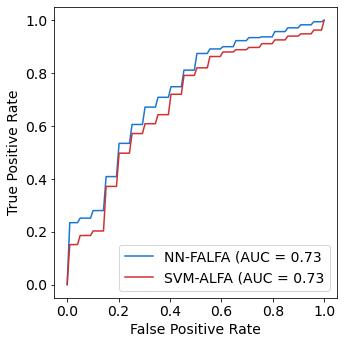

In [5]:
FIGSIZE = (5, 5)
NAMES = [
    'NN-FALFA',
    'SVM-ALFA',
]
# Save color as accuracy plot. [Blue, Red]
COLORS = ['#1976d2', '#d32f2f']
FONTSIZE = 14

tprsA = []
tprsB = []
mean_fpr = np.linspace(0, 1, 100)

def get_mean_roc(tprs, df):
    tpr = df['tpr']
    fpr = df['fpr']

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr[-1] = 1.0

    tprs.append(interp_tpr)

for workspace in workspace_names:
    dfA = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', rocA))
    dfB = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', rocB))

    get_mean_roc(tprsA, dfA)
    get_mean_roc(tprsB, dfB)

mean_tprA = np.mean(tprsA, axis=0)
mean_tprA[-1] = 1.0
aucA = auc(mean_fpr, mean_tprA)

mean_tprB = np.mean(tprsB, axis=0)
mean_tprB[-1] = 1.0
aucB = auc(mean_fpr, mean_tprA)

plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(mean_fpr, mean_tprA, color=COLORS[0], label=f'{NAMES[0]} (AUC = {aucA:.2f}')
ax.plot(mean_fpr, mean_tprB, color=COLORS[1], label=f'{NAMES[1]} (AUC = {aucB:.2f}')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.tight_layout()
path_output = os.path.join(PATH_ROOT, 'results', 'roc_real_repeated.pdf')
plt.savefig(path_output, dpi=300)